# Henrylab Coding Test

All code should be shown in this jupyter notebook. 

### Instructions###

1. Download the anatomical images of 5 subjects from the [ABIDE dataset](http://preprocessed-connectomes-project.org/abide/download.html). 
    * For example, one URL to downnload is: http://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/RawData/Pitt/0050008/session_1/anat_1/mprage.nii.gz , where the subject id is 0050008
    
2. Set up an anaconda python environment: https://www.continuum.io/downloads and install the nipype and nilearn packages
    ```bash 
conda create --name env_name python=3 anaconda
conda config --add channels conda-forge
conda install -y nipype
conda install -y nilearn
```

3. Download and install [FSL](https://fsl.fmrib.ox.ac.uk/fsldownloads/)

4. Read the tutorial on [nipype interfaces](https://miykael.github.io/nipype_tutorial/notebooks/basic_interfaces.html) and do the following:
    * For each subject, create a brain mask using FSL's BET through nipype interfaces. 
    * Create images for each brain mask overlaid on the original anatomica image using nilearn's plotting tools (Hint: use [plot_roi](http://nilearn.github.io/auto_examples/01_plotting/plot_demo_plotting.html#plotting-rois-here-the-mask-with-function-plot-roi) ) in this noteboook
    
5. Read the tutorial on [nipype workflows](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html) and do the following:
    * Create a workflow that runs BET on 1 subject, and then runs FSL's [FAST](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.fsl.preprocess.html#fast) to segment gray and white matter, CSF. The masked brain (BET output) is what FAST should use to segment.
    * Create and display an image of the workflow using `workflow.write_graph()`
    
6. Read the tutorial on the [DataGrabber](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html) and [DataSink](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_output.html) nodes and:
    * define a datagrabber node that takes in a subject_id field and returns the path to the T1 image. Connect the output of the datagrabber to the input of the BET node 
    * define a datasink node that saves the output probability images of FAST and the brain-mask from BET.
    * Create images of the probability maps from FAST using nilearn's plotting tools (Hint: use [plot_stat_map](http://nilearn.github.io/auto_examples/01_plotting/plot_demo_plotting.html#plotting-statistical-maps-with-function-plot-stat-map))
    * display the workflow graph
    
7. Look at documentation for the [IdentityInterface](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html) and:
    * Create an identity node that takes in a subject_id
    * connect the subject_id output of the identity node to the subject_id input of the datagrabber
    * display the worflow graph
    
8. Read the second tutorial on [nipype workflows](https://miykael.github.io/nipype_tutorial/notebooks/basic_iteration.html) on iterables and iterfields. 
    * Define an iterable on the IdentityInterface's subject_id, as a list of all 5 subject ids
    * Run the workflow on all 5 subjects
    
9. Read the documentation on [Function Nodes](https://miykael.github.io/nipype_tutorial/notebooks/basic_function_interface.html)
    * Write a function that takes in a probability image and base T1 image and saves a .png file. The function should return the path to the .png image. 
    * Wrap your visualization function in a Function Node
    * Connect the Function node to the outputs of the DataGrabber (for the base T1 image) and the output of FAST (for the probability image). 
    * Connect the output of the function node to the DataSink Node
    * Display the graph
    * Run the workflow


## 4. Nipype interfaces

#### 4.1 Brain Masking from FSL's BET

In [1]:
import nipype
import nipype.interfaces.io as nio
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nilearn.plotting import plot_anat
from numpy import append
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn import plotting
from nipype import Node, Workflow
from os.path import abspath
from IPython.display import Image
import os
from nipype import IdentityInterface

%matplotlib inline
%pylab inline
%cd '/Users/alexandrasentis/Downloads/'

subjects=['0050005.nii.gz','0050006.nii.gz','0050007.nii.gz','0050008.nii.gz','0050009.nii.gz']

Populating the interactive namespace from numpy and matplotlib
/Users/alexandrasentis/Downloads


/Users/alexandrasentis/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plotting']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


/Users/alexandrasentis/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


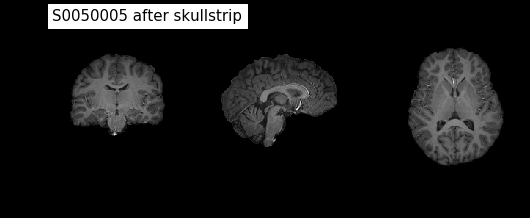

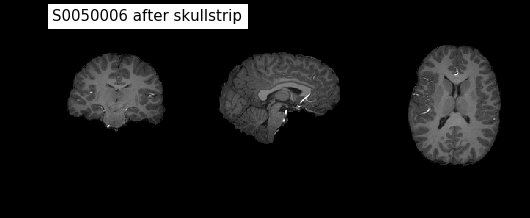

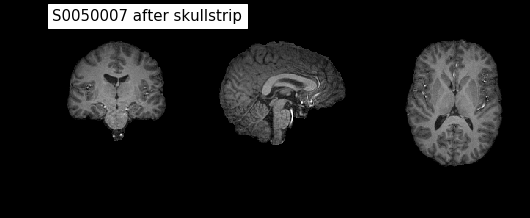

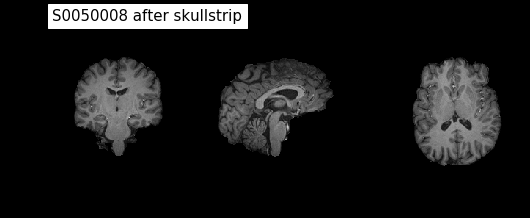

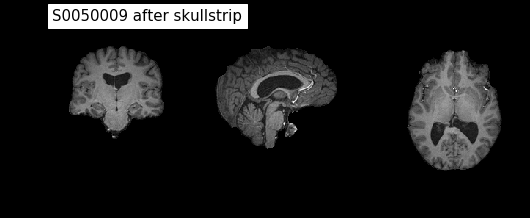

In [2]:
subjects_bet=[]
for n in subjects:
    in_file=n
    out_file='brain_'+n
    skullstrip = fsl.BET(in_file=in_file,out_file=out_file, mask=False)
    res = skullstrip.run()
    plot_anat(out_file, title='S'+n[:7]+' after skullstrip', display_mode='ortho', dim=-1, draw_cross=False, annotate=False);
    subjects_bet.append(out_file)

#### 4.2 Images of brain masks using nilearn

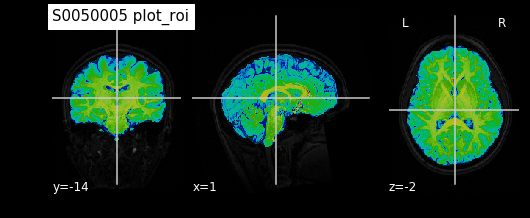

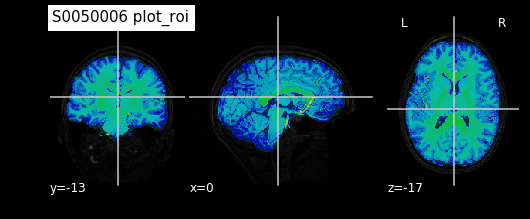

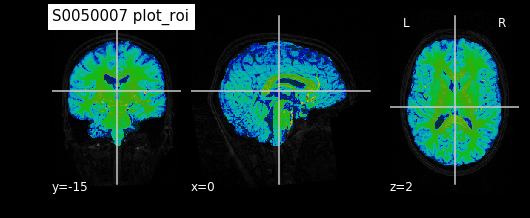

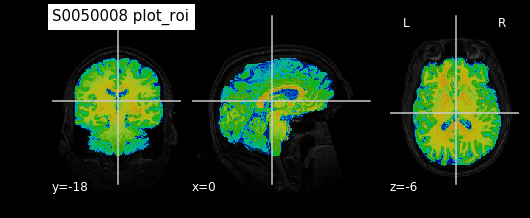

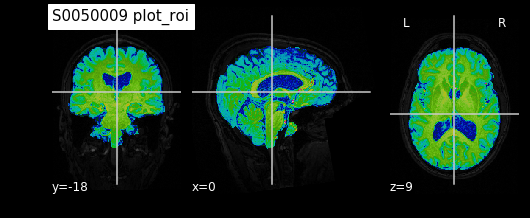

In [3]:
for i,n in enumerate(subjects):
    plot_roi(subjects_bet[i], bg_img=n, title='S'+n[:7]+' plot_roi')

## 5. Nipype Workflows

In [4]:
in_file = abspath("0050008.nii.gz")

# Define Nodes
skullstrip = Node(fsl.BET(mask=False,in_file=in_file, output_type='NIFTI_GZ'), name="skullstrip")

segmentation=Node(fsl.FAST(out_basename='fast_'), name='segmentation')

# Initiation of a Workflow (BET output --> FAST input)
wf = Workflow(name="Step5", base_dir="output/working_dir")
wf.connect(skullstrip, 'out_file', segmentation, "in_files")
wf.run()


/Users/alexandrasentis/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


190305-13:36:24,387 nipype.workflow INFO:
	 Workflow Step5 settings: ['check', 'execution', 'logging', 'monitoring']
190305-13:36:24,405 nipype.workflow INFO:
	 Running serially.
190305-13:36:24,407 nipype.workflow INFO:
	 [Node] Setting-up "Step5.skullstrip" in "/Users/alexandrasentis/Downloads/output/working_dir/Step5/skullstrip".
190305-13:36:24,414 nipype.workflow INFO:
	 [Node] Running "skullstrip" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /Users/alexandrasentis/Downloads/0050008.nii.gz /Users/alexandrasentis/Downloads/output/working_dir/Step5/skullstrip/0050008_brain.nii.gz


/Users/alexandrasentis/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


190305-13:36:28,620 nipype.workflow INFO:
	 [Node] Finished "Step5.skullstrip".
190305-13:36:28,621 nipype.workflow INFO:
	 [Node] Setting-up "Step5.segmentation" in "/Users/alexandrasentis/Downloads/output/working_dir/Step5/segmentation".
190305-13:36:28,628 nipype.workflow INFO:
	 [Node] Running "segmentation" ("nipype.interfaces.fsl.preprocess.FAST"), a CommandLine Interface with command:
fast -o fast_ -S 1 /Users/alexandrasentis/Downloads/output/working_dir/Step5/segmentation/0050008_brain.nii.gz
190305-13:40:24,638 nipype.workflow INFO:
	 [Node] Finished "Step5.segmentation".


190305-13:40:25,164 nipype.workflow INFO:
	 Generated workflow graph: output/working_dir/Step5/workflow_graph.png (graph2use=hierarchical, simple_form=True).


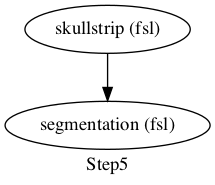

In [5]:
# Produce graph of workflow
wf.write_graph("workflow_graph.dot")
Image(filename="output/working_dir/Step5/workflow_graph.png")

## 6. DataGrabber and DataSink

In [6]:
# Create Nodes

# Data Grabber process
dg = Node(nio.DataGrabber(infields=['subject_id'],outfields=['image_file']), name="datagrabber")
# Location of the dataset folder
dg.inputs.base_directory = os.getcwd()
dg.inputs.template='%s.nii.gz'
dg.inputs.sort_filelist = True

# Skullstrip process
skullstrip = Node(fsl.BET(mask=False,output_type='NIFTI_GZ'), name="skullstrip")

# FAST process
segmentation = Node(fsl.FAST(out_basename='fast_', probability_maps=True), name='segmentation')

#Data Sink process
datasink = Node(nio.DataSink(), name='datasinker')
datasink.inputs.base_directory = abspath('output/working_dir/Step6/datasinker')

In [ ]:
# Create workflow
wf = Workflow(name="Step6", base_dir="output/working_dir")
wf.connect([(dg, skullstrip, [("image_file", "in_file")]), (skullstrip, segmentation, \
        [("out_file", "in_files")]), (segmentation, datasink, [('probability_maps', 'FAST')]), \
        (skullstrip, datasink, [('out_file', 'skullstrip')])])

dg.inputs.subject_id = ['0050008']
wf_results=wf.run()


190305-13:40:34,887 nipype.workflow INFO:
	 Workflow Step6 settings: ['check', 'execution', 'logging', 'monitoring']
190305-13:40:34,904 nipype.workflow INFO:
	 Running serially.
190305-13:40:34,905 nipype.workflow INFO:
	 [Node] Setting-up "Step6.datagrabber" in "/Users/alexandrasentis/Downloads/output/working_dir/Step6/datagrabber".
190305-13:40:34,911 nipype.workflow INFO:
	 [Node] Running "datagrabber" ("nipype.interfaces.io.DataGrabber")
190305-13:40:34,917 nipype.workflow INFO:
	 [Node] Finished "Step6.datagrabber".
190305-13:40:34,918 nipype.workflow INFO:
	 [Node] Setting-up "Step6.skullstrip" in "/Users/alexandrasentis/Downloads/output/working_dir/Step6/skullstrip".
190305-13:40:34,923 nipype.workflow INFO:
	 [Node] Running "skullstrip" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /Users/alexandrasentis/Downloads/0050008.nii.gz /Users/alexandrasentis/Downloads/output/working_dir/Step6/skullstrip/0050008_brain.nii.gz
190305-13:40:39,82 nip

In [ ]:
# Plot workflow
wf.write_graph("workflow_graph.dot", graph2use='flat')
Image(filename="output/working_dir/Step6/workflow_graph_detailed.png")

In [ ]:
# Plot probability maps
from nilearn import plotting
plot_map0=abspath('output/working_dir/Step6/datasinker/FAST/fast__prob_0.nii.gz')
plot_map1=abspath('output/working_dir/Step6/datasinker/FAST/fast__prob_1.nii.gz')
plot_map2=abspath('output/working_dir/Step6/datasinker/FAST/fast__prob_2.nii.gz')

plotting.plot_stat_map(plot_map0, title="plot_stat_map", bg_img=None)
plotting.plot_stat_map(plot_map1, title="plot_stat_map", bg_img=None)
plotting.plot_stat_map(plot_map2, title="plot_stat_map", bg_img=None)

## 7. IdentityInterfaces

In [ ]:
# Create Nodes

# Create Identity Node
infosource = Node(IdentityInterface(fields=['subject_id']),name="infosource")
infosource.inputs.subject_id='0050008'
subject = infosource.run()
print('Subject ID: ' + subject.outputs.subject_id)

# Data Grabber process
dg = Node(nio.DataGrabber(infields=['subject_id'],outfields=['image_file']), name="datagrabber")
# Location of the dataset folder
dg.inputs.base_directory = os.getcwd()
dg.inputs.template='%s.nii.gz'
dg.inputs.sort_filelist = True

# Skullstrip process
skullstrip = Node(fsl.BET(mask=False,output_type='NIFTI_GZ'), name="skullstrip")

# FAST process
segmentation = Node(fsl.FAST(out_basename='fast_', probability_maps=True), name='segmentation')

#Data Sink process
datasink = Node(nio.DataSink(), name='datasinker')
datasink.inputs.base_directory = abspath('output/working_dir/Step7/datasinker')

In [ ]:
wf = Workflow(name="Step7", base_dir="output/working_dir")
wf.connect(infosource,'subject_id',dg,'subject_id')
wf.connect([(dg, skullstrip, [("image_file", "in_file")]), (skullstrip, segmentation, \
        [("out_file", "in_files")]), (segmentation, datasink, [('probability_maps', 'FAST')]), \
        (skullstrip, datasink, [('out_file', 'skullstrip')])])
results=wf.run()

## 8. Iterables and Iterfields

In [ ]:
# Create Nodes

# Create Identity Node
infosource = Node(IdentityInterface(fields=['subject_id']),name="infosource")
infosource.iterables = [('subject_id', subjects)]
print('Subject ID: ' + subject.outputs.subject_id)

# Data Grabber process
dg = Node(nio.DataGrabber(infields=['subject_id'],outfields=['image_file']), name="datagrabber")
# Location of the dataset folder
dg.inputs.base_directory = os.getcwd()
dg.inputs.template='%s'
dg.inputs.sort_filelist = True

# Skullstrip process
skullstrip = Node(fsl.BET(mask=False,output_type='NIFTI_GZ'), name="skullstrip")

# FAST process
segmentation = Node(fsl.FAST(out_basename='fast_', probability_maps=True), name='segmentation')

#Data Sink process
datasink = Node(nio.DataSink(), name='datasinker')
datasink.inputs.base_directory = abspath('output/working_dir/Step8/datasinker')

In [ ]:
wf = Workflow(name="Step8", base_dir="output/working_dir")
wf.connect(infosource,'subject_id',dg,'subject_id')
wf.connect([(dg, skullstrip, [("image_file", "in_file")]), (skullstrip, segmentation, \
        [("out_file", "in_files")]), (segmentation, datasink, [('probability_maps', 'FAST')]), \
        (skullstrip, datasink, [('out_file', 'skullstrip')])])
results=wf.run()

## 9. Function Nodes